In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

#Bag of words technique
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

#Imports para visualizacion
from matplotlib.gridspec import GridSpec

#Imports para creacion del modelo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
import string

In [32]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
#Cargamos nuestro dataset
df = pd.read_csv('UpdatedResumeDataSet.csv')

In [34]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [35]:
"""
Podemos ver las diferentes categorias que el dataset puede clasificar un CV.
"""
df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [36]:
df.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [37]:
count=df['Category'].value_counts()
label=df['Category'].value_counts().keys()

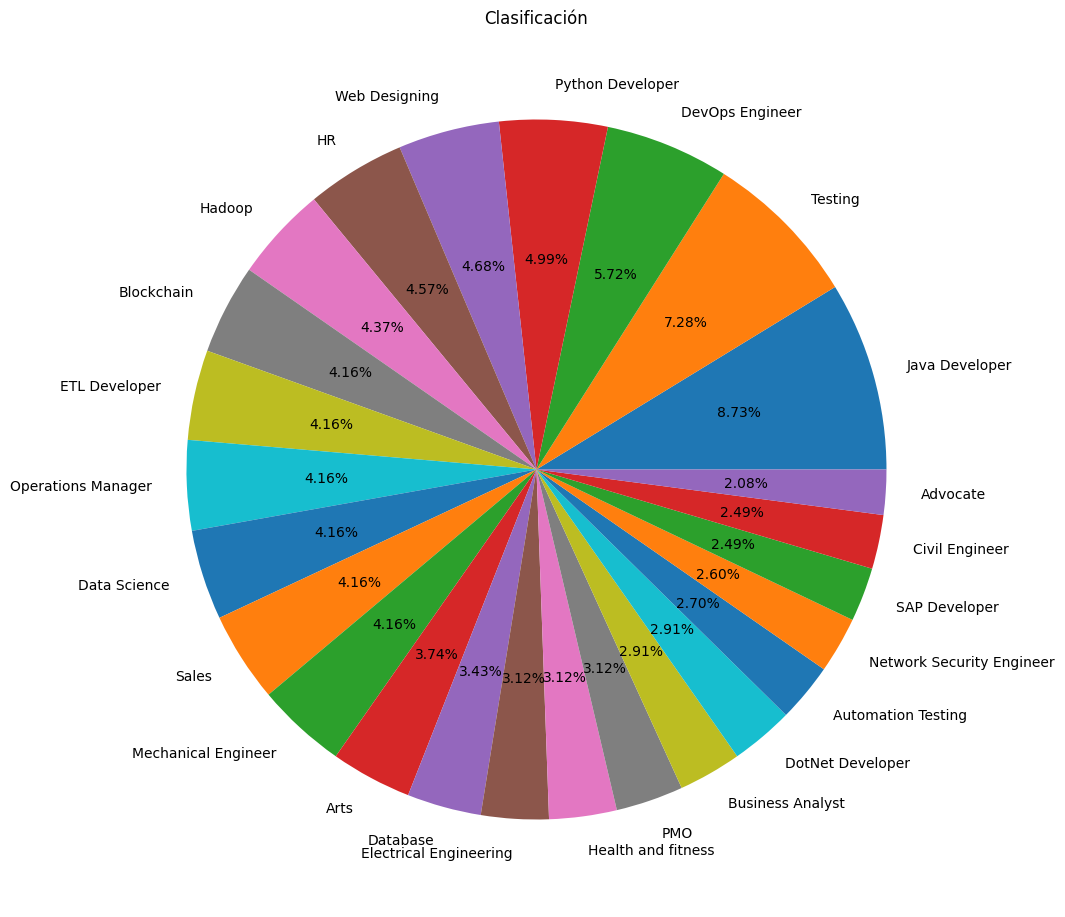

In [38]:
plt.figure(1, figsize=(25,25))
grid=GridSpec(2,2)
cmap=plt.get_cmap('coolwarm')

color=[cmap(i) for i in np.linspace(0, 1, 5)]
plt.subplot(grid[0,1], aspect=1, title='Clasificación')

pie=plt.pie(count, labels=label, autopct='%1.2f%%')
plt.show()

In [39]:
"""
Preprocesamiento de los datos

Aqui borramos todos los caractéres sobrantes de las palabras
relacionadas a cada una de las profesiones.
"""

def Limpiador(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)
    resumeText = re.sub('RT|cc', ' ', resumeText)
    resumeText = re.sub('#\S+', '', resumeText)
    resumeText = re.sub('@\S+', '  ', resumeText)
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)
    return resumeText

In [40]:
df.head(10)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


In [41]:
df['CV_limpio']=df.Resume.apply(lambda x: Limpiador(x))

In [42]:
"""
Mostramos la comparativa y creamos una nueva columna con los datos limpios.
"""
df.head(10)

,Category,Resume,CV_limpio
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",SKILLS C Basics IOT Python MATLAB Data Science...
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,Skills Python Tableau Data Visualization R Stu...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,Education Details B Tech Rayat and Bahra Insti...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,Personal Skills Ability to quickly grasp techn...
9,Data Science,Expertise â Data and Quantitative Analysis â...,Expertise Data and Quantitative Analysis Decis...


In [43]:
new_Resume_df = df.copy()

# Técnica de Bag of words

In [44]:
"""
Dentro de esta técnica lo que hacemos es la recopilación de palabras valiosas
como las palabras más frecuentes y los patrones temáticos.

Para esto utilizamos stopwords, ya que esto lo que hace es limpiar la cadena de texto
por medio de la eliminacion de conectores de palabras como lo puede ser "the", "a", "then".

Lo que hace es un diccionario donde analiza todas las palabras dentro del documento
y almacena la palabra con la frecuencia de la misma.


1: Creación del vocabulario: Se crea un conjunto de palabras único a partir de
   todos los documentos de texto que se van a analizar.

2: Vectorización del texto: Cada documento de texto se convierte en un vector
   de igual tamaño que el vocabulario creado. Las palabras que aparecen en un
   documento se convierten en un valor de uno en el vector, mientras que las
   palabras que no aparecen en el documento se convierten en un valor cero.

3: Normalización del peso: Se normalizan los vectores para tener una magnitud consistente.
   Esto se realiza dividiendo cada valor del vector por la suma de los valores en el vector.
   Una vez que se ha creado la matriz BoW.
"""

oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['Resume'].values
cleanedSentences = ""

for records in Sentences:
    cleanedText = Limpiador(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('Exprience', 3829), ('months', 3233), ('company', 3130), ('Details', 2967), ('description', 2634), ('1', 2134), ('Project', 1808), ('project', 1579), ('6', 1499), ('data', 1438), ('team', 1424), ('Maharashtra', 1385), ('year', 1244), ('Less', 1137), ('January', 1086), ('using', 1041), ('Skill', 1018), ('Pune', 1016), ('Management', 1010), ('SQL', 990), ('Ltd', 934), ('management', 927), ('C', 896), ('Engineering', 855), ('Education', 833), ('Developer', 806), ('Java', 773), ('2', 754), ('development', 752), ('monthsCompany', 746), ('Pvt', 730), ('application', 727), ('System', 715), ('reports', 697), ('business', 696), ('India', 693), ('requirements', 693), ('I', 690), ('various', 688), ('A', 688), ('Data', 674), ('The', 672), ('University', 656), ('process', 648), ('Testing', 646), ('test', 638), ('Responsibilities', 637), ('system', 636), ('testing', 634), ('Software', 632)]


In [45]:
"""
Hacemos que cada uno de las categorias a las que puede clasificarse un CV
sean numericas para ser soportadas por el modelo por lo que usamos el label encoder.
"""
integers = LabelEncoder()
df['Category'] = integers.fit_transform(df['Category'])
df.head()

,Category,Resume,CV_limpio
0,6,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,6,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


In [46]:
df.Category.value_counts(), new_Resume_df.Category.value_counts()

(15    84
 23    70
 8     55
 20    48
 24    45
 12    44
 13    42
 3     40
 10    40
 18    40
 6     40
 22    40
 16    40
 1     36
 7     33
 11    30
 14    30
 19    30
 4     28
 9     28
 2     26
 17    25
 21    24
 5     24
 0     20
 Name: Category, dtype: int64,
 Java Developer               84
 Testing                      70
 DevOps Engineer              55
 Python Developer             48
 Web Designing                45
 HR                           44
 Hadoop                       42
 Blockchain                   40
 ETL Developer                40
 Operations Manager           40
 Data Science                 40
 Sales                        40
 Mechanical Engineer          40
 Arts                         36
 Database                     33
 Electrical Engineering       30
 Health and fitness           30
 PMO                          30
 Business Analyst             28
 DotNet Developer             28
 Automation Testing           26
 Network Security Engineer

In [47]:
text = df['CV_limpio'].values
target = df['Category'].values

word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
word_vectorizer.fit(text)
WordFeatures = word_vectorizer.transform(text)

In [48]:
X_train,X_test,y_train,y_test = train_test_split(WordFeatures,target,random_state=42, test_size=0.2, shuffle=True, stratify=target)
print(X_train.shape)
print(X_test.shape)

(769, 7351)
(193, 7351)


In [51]:
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set:     0.98


In [54]:
prediction

array([10, 14,  0, 11, 18, 19, 15,  5, 18, 18, 12,  6, 15,  8,  3, 10, 16,
       23,  6, 15, 20, 19, 12, 21,  8,  6,  7,  6, 17, 12,  1, 21, 22,  5,
       22, 17, 10, 12, 15, 15, 22,  5,  1,  4, 23, 24,  8,  6, 15, 15, 11,
       23, 19, 14,  8, 16,  8, 23,  9,  4, 12, 15,  6, 15,  8,  3, 18, 24,
        2, 10, 23,  2, 22, 13,  0, 15, 19,  2, 13,  0, 20, 14,  1, 16, 21,
        9, 23, 20, 23, 17, 18, 24, 10, 13, 20,  1, 10,  8, 11,  7,  7, 14,
       24, 22, 13, 15,  6,  9, 14,  3,  4, 15, 20,  4, 11, 15, 16, 15,  0,
       13, 15, 19,  6, 10, 20,  3, 13, 12,  8, 11, 24, 16, 11,  6, 21, 18,
       18, 14,  5,  7,  1,  5, 13, 15, 12, 20, 23,  3, 20, 24, 18, 23, 12,
       17, 15,  9,  1, 12, 16,  3, 20, 23,  7, 20, 22, 16, 23, 24, 23, 17,
        7, 23, 11,  1,  8, 13, 19, 23,  8, 10,  4, 24,  3,  2,  3,  4,  9,
       22, 24, 21, 23, 22, 16])

In [59]:
# Testing example
sample_resume = "I am a highly motivated and skilled data scientist with a passion for machine learning and natural language processing."

# Preprocessing
cleaned_text = Limpiador(sample_resume)
required_words = nltk.word_tokenize(cleaned_text)
one_set_of_stop_words = set(stopwords.words('english') + ['``', "''"])
total_words = [word for word in required_words if word not in one_set_of_stop_words and word not in string.punctuation]

# Vectorizing
word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
word_vectorizer.fit([cleaned_text])
word_features = word_vectorizer.transform([cleaned_text])

clf = KNeighborsClassifier()

X_train_vectorized = word_vectorizer.transform(X_train)

clf.fit(X_train_vectorized, y_train)
prediction = clf.predict(word_features)
print('Predicted Category:', prediction[0])


Predicted Category: 6
